In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor


## Завантаження та дослідження датасету

Завантаження набору у датафрейм Pandas та дослідження його характеристик

In [7]:
# https://www.kaggle.com/datasets/mohidabdulrehman/ultimate-car-price-prediction-dataset
df = pd.read_csv('car_prices.csv')

# видалення першої колонки
df = df.drop(df.columns[0], axis=1)

# Показ перших 5 рядків
df.head()

,Company Name,Model Name,Price,Model Year,Location,Mileage,Engine Type,Engine Capacity,Color,Assembly,Body Type,Transmission Type,Registration Status
0,Toyota,Vitz,2385000,2017,Islamabad,9869,Petrol,1000,Silver,Imported,Hatchback,Automatic,Un-Registered
1,Toyota,Corolla,111000,2019,KPK,11111,Petrol,1300,White,Local,Sedan,Automatic,Registered
2,Suzuki,Alto,1530000,2019,KPK,17500,Petrol,660,White,Local,Hatchback,Automatic,Un-Registered
3,Suzuki,Alto,1650000,2019,Punjab,9600,Petrol,660,White,Local,Hatchback,Manual,Registered
4,Toyota,Corolla,1435000,2010,Islamabad,120000,Petrol,1300,Black,Local,Sedan,Manual,Registered


In [8]:
# Статистика даних (кількість, середнє, стандартне відхилення, мінімальне та максимальне значення)
df.describe()

,Price,Model Year,Mileage,Engine Capacity
count,4.602200e+04,46022.000000,46022.000000,46022.000000
mean,2.014153e+06,2011.035374,90965.128243,1313.115575
std,2.939071e+06,6.399403,63656.656034,614.690832
min,1.110000e+05,1990.000000,1.000000,16.000000
25%,8.500000e+05,2007.000000,48899.500000,1000.000000
50%,1.450000e+06,2013.000000,80000.000000,1300.000000
75%,2.300000e+06,2016.000000,120000.000000,1500.000000
max,7.750000e+07,2019.000000,999999.000000,6600.000000


In [37]:
# Кількітьсть унікальних значень в кожному стовпці
df.nunique()

Company Name             31
Model Name              196
Price                  1419
Model Year               30
Location                  6
Mileage                5573
Engine Type               3
Engine Capacity          75
Color                    24
Assembly                  2
Body Type                 6
Transmission Type         2
Registration Status       2
dtype: int64

In [39]:
for c in df.columns:
    print(c + ': ', sorted(df[c].unique()))

Company Name:  ['Adam', 'Audi', 'BMW', 'Chery', 'Chevrolet', 'DFSK', 'Daewoo', 'Daihatsu', 'FAW', 'Fiat', 'Honda', 'Hummer', 'Hyundai', 'Jaguar', 'Jeep', 'KIA', 'Land', 'Lexus', 'MINI', 'Mazda', 'Mercedes', 'Mitsubishi', 'Nissan', 'Porsche', 'Range', 'SsangYong', 'Subaru', 'Suzuki', 'Toyota', 'United', 'Volvo']
Model Name:  ['3', '5', '7', 'A3', 'A4', 'A5', 'A6', 'A7', 'APV', 'Accord', 'Acty', 'Allion', 'Alphard', 'Altezza', 'Alto', 'Aqua', 'Auris', 'Avanza', 'Aveo', 'Axela', 'Aygo', 'Azwagon', 'B', 'Baleno', 'Bego', 'Belta', 'Benz', 'Blue', 'Bluebird', 'Bolan', 'Boon', 'Bravo', 'C-HR', 'C37', 'CJ', 'CR-V', 'CT200h', 'Caldina', 'Cami', 'Camry', 'Carol', 'Cast', 'Cayenne', 'Cefiro', 'Celerio', 'Cervo', 'Charade', 'Ciaz', 'City', 'Civic', 'Clipper', 'Convoy', 'Cooper', 'Corolla', 'Corona', 'Coupe', 'Cross', 'Crown', 'Cultus', 'Cuore', 'Dayz', 'Dias', 'Duet', 'EK', 'Ek', 'Esse', 'Estima', 'Excel', 'Exclusive', 'FX', 'Familia', 'Fit', 'Flair', 'Fortuner', 'Freed', 'Galant', 'Glory', 'Grace

In [9]:
# Перевірка на пропущені значення
df.isna().sum()

Company Name           0
Model Name             0
Price                  0
Model Year             0
Location               0
Mileage                0
Engine Type            0
Engine Capacity        0
Color                  0
Assembly               0
Body Type              0
Transmission Type      0
Registration Status    0
dtype: int64

In [10]:
# Типи даних в кожному стовпці
df.dtypes

Company Name           object
Model Name             object
Price                   int64
Model Year              int64
Location               object
Mileage                 int64
Engine Type            object
Engine Capacity         int64
Color                  object
Assembly               object
Body Type              object
Transmission Type      object
Registration Status    object
dtype: object

## Препроцессинг даних

### Робота з пропущеними значеннями

Видаленя тих записів, у яких є відсутні значення

In [11]:
df.dropna(inplace=True)

### Кодування категоріальних значень

Конвертування категоріальних значень у числові. За допомогою One Hot Encoding

In [20]:
categorical_features = ['Company Name', 'Model Name', 'Engine Type', 'Color', 'Transmission Type']
numerical_features = ['Model Year', 'Mileage', 'Engine Capacity']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

### Розбиття даних

Розділення датасету на навчальну і тестові вибірки.

In [21]:
X = df.drop('Price', axis=1)
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)


## Тренування моделей

Конвеєри для різних моделей. Випробовування моделей Linear Regression, Decision Tree, Random Forest, та K-Nearest Neighbors

In [22]:
# Linear Regression

lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', LinearRegression())])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

print(f"Linear Regression RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr))}")
print(f"Linear Regression R^2: {r2_score(y_test, y_pred_lr)}")


Linear Regression RMSE: 1601374.9199605715
Linear Regression R^2: 0.7180811770434452


In [23]:
#  Decision Tree

dt_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', DecisionTreeRegressor())])

dt_pipeline.fit(X_train, y_train)
y_pred_dt = dt_pipeline.predict(X_test)

print(f"Decision Tree RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_dt))}")
print(f"Decision Tree R^2: {r2_score(y_test, y_pred_dt)}")


Decision Tree RMSE: 655384.2947304758
Decision Tree R^2: 0.9527795535896448


In [24]:
# Random Forest

rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', RandomForestRegressor())])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

print(f"Random Forest RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf))}")
print(f"Random Forest R^2: {r2_score(y_test, y_pred_rf)}")


Random Forest RMSE: 539884.5397678824
Random Forest R^2: 0.9679565100145611


In [25]:
#  K-Nearest Neighbors

knn_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', KNeighborsRegressor())])

knn_pipeline.fit(X_train, y_train)
y_pred_knn = knn_pipeline.predict(X_test)

print(f"KNN RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_knn))}")
print(f"KNN R^2: {r2_score(y_test, y_pred_knn)}")


KNN RMSE: 582372.5999301267
KNN R^2: 0.9627145064864668


## Оцінка моделей

Порівняння ефективності за метриками Root Mean Squared Error (RMSE) та R² score.

In [ ]:
#####

## Підбір гіперпараметрів

GridSearchCV для пошуку найкращих параметрів для способу із K-Nearest Neighbors

In [28]:
param_grid = {
    'regressor__n_neighbors': [3, 5, 8, 12, 15],
    'regressor__weights': ['uniform', 'distance'],
    'regressor__metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(estimator=knn_pipeline, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

y_pred_best = best_model.predict(X_test)
print(f"Optimized K-Nearest Neighbors RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_best))}")
print(f"Optimized K-Nearest Neighbors R^2: {r2_score(y_test, y_pred_best)}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'regressor__metric': 'manhattan', 'regressor__n_neighbors': 5, 'regressor__weights': 'distance'}
Optimized K-Nearest Neighbors RMSE: 619676.5349672735
Optimized K-Nearest Neighbors R^2: 0.9577848700056669


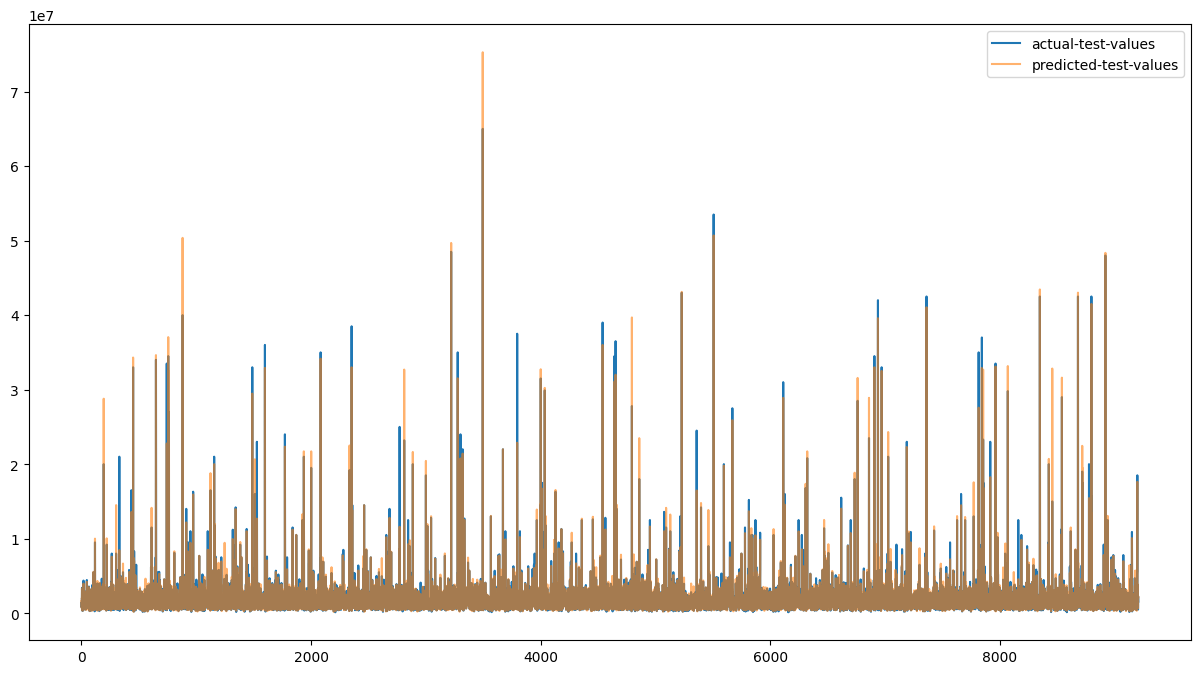

In [35]:
# візуалізація тестових та прогнозованих значень
plt.figure(figsize=(15, 8))
plt.plot([i for i in range(len(y_test))],y_test, label="actual-test-values")
plt.plot([i for i in range(len(y_test))],y_pred_best, label="predicted-test-values", alpha=0.6)
plt.legend()
plt.show()

## Збереження фінальної моделі

In [36]:
import joblib
joblib.dump(best_model, 'car_price_predictor.pkl')


['car_price_predictor.pkl']